# Bayesian Statistics and Machine Learning (part two)

Our previous Notebooks introduced using Bayes' theorem with real numbers. While this is useful, where we really see it applied in ML is using distributions rather than actual numbers. Conceptually, however, the process is the same.

Let's first remind ourselves of Bayes' rule:
<br><br>
$ \huge P(A|B) = \frac{P(B|A) ~ P(A)}{P(B)} $
<br><br>
Nothing essentially has changed except everything is now a distribution. We know that our likelihood ($P(B|A)$) is going to be the data we collected ... and therefore this will come as a distribution. In the previous Notebook we reduced this down to just a number by calculating the frequency of the thing of interest &nbsp; ($P(B)$), but we also should see that this is a very "frequentist" way of doing things. Here we will keep it as a full distribution and pass all the data. This now means that we now want our prior ($P(A)$) to be a distribution, which we can do by converting our belief to a set of parameters in a distribution. 

This also means we will produce on the other side a posterior ($P(A|B)$) that is a distribution. Again this is a much more Bayesian representation of our results; rather than giving an answer that is a single number we will instead present a range of values with a variety of likelihoods. Of course we can still give a single number - the average of the posterior distribution - but we also can give some idea of the _uncertainty_ around this number by detailing the degree of variation in our distribution.

It finally means that our evidence ($P(B)$) is also a distribution. Unfortunately this can make it much harder to caclulate analytically, so typically we have to resort to a hack of some kind, as we will discuss later. Before we get into our example, its worth spending a moment reminding ourselves about how statistical distributions work.

## Statistical Distributions and Probabilistic Programming
Although you would have seen these on a previous model, it is probably worth a quick refresher with some extra context on what we care about in this particular case. Let's start with an old favourite - the Gaussian or Normal Distribution:
<br><br><img src="normal.png" alt="Gaussian distribution" width="750"/><br><br>
As we can see in the above, a true Gaussian distribution has two parameters that effectively define it for a give dataset: 
* $\mu$ - the mean average of the distribution
* $\sigma$ - the standard deviation of the distribution

Further to this, once we have fit a distribution to our data, and it is worth pointing out here that our distribution is effectively a model of our data (with the usual expectation that there will be error and variation), then from this we can calculate the probability of any value in our data. In the case of a Gaussian, we can say that 68% of our data will be within one $\sigma$ of the $\mu$, 95% of data will be within two $\sigma$ and 99% within three $\sigma$. In other words, if we have a distribution with $\mu = 0$ and $\sigma = 1$ (we call this a non-informative Gaussian and its important in deep learning), the we can say 68% of values will be between -1 and 1, 95% between -2 and 2, and so on. 

The above representation is called the PDF (probability density function ... not portable document format) of the distribution. We also may want to plot a CDF (culmative density function) which would look something like this:
<br><br><img src="normalCDF.png" alt="Gaussian CDF" width="750"/><br><br>
The CDF, as the name suggests, sums up the probabilities as we pass through each value. Effectively the probability given (the Y-axis) is for a randomly selected value being this value of smaller. I.e. the probability of drawing a value that is smaller or equal to $\mu - 3\sigma$ would be less than 0.01; the probability of drawing value that is $\mu$ or smaller would be 0.5; and the probability of a value <= $\mu + 3\sigma$ approaches 1.0.

Combining this with our standard programming concepts, we can create variables that store such a distribution. Consider the following psuedo-code:

In [1]:
# Pseudo-code - will not run
# mydist = normal(mu=0, sigma=1)

We can then use this variable in a more non-deterministic fashion than we do in normal programming. We could draw values from this varibale with the probabilities associated with the distribution (e.g. there would be a 68% chance a number drawn would be be $\mu \pm \sigma$ ... in the range -1 to 1).

Given that we now want to define our Bayesian equation as a set of distributions, probabilistic programming approaches are what we are looking for. There are multiple ways to do this in Python, including TensorFlow Probability (TFP) which we will use in the module. However, for this Notebook we will use PyMC3. 

## A Bayesian Coin Flip
For our example, we will turn to the "Hello, World" / MNIST Hand-Written Digits of probabilistic programming ... tossing a coin. As we know, an unbiased coin will land heads half the time, and tails the other. But what if our coin was biased? What if if it were more likely to land on one one than the other? How might we go about measuring this? Let's start by tossing the coin: 

In [2]:
import numpy as np
from scipy import stats

np.random.seed(123) # specify random seed so results are repeated
trials = 4 # effectively 4x coin tosses
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

Here we have modelled our coin flip as a Bernoulli distribution. The Bernoulli is constructed as:
<br><br><img src="binomial.png" alt="Bernoulli distribution, Source: https://programmathically.com/wp-content/uploads/2021/01/Binomial_distribution_pmf-2048x1364.png" width="750"/><br><br>Again there are two key parameters:
* $n$ - the number of trials (e.g. times we flip the coin)
* $p$ - the probability of a given result (e.g. the probability the result is heads ... for an unbiased coin it would be 0.5)

In the above example, we have created a biased coin so the probability of heads is only 0.35 (a 0.65 chance of tails) and we have conducted 4 trials (heads, tails, tails, tails) ... in other words $p=0.35,~n=4$.

Effectively we have our data ... the likelihood. The next, step will be to create a prior. In Bayesian statistics, the distribution of our likelihood should impact our choice for the distribution of our prior. There is a long, complicated reason behind this to do with calculating the integral of the pesky denominator ... $P(B)$ ... but we'll ignore that for now. Instead we just need to know that for every distribution our likelihood may have, our prior will have a suitable matching distribution know as the _conjugate_. In the case of a Gaussian the conjugate is also a Gaussian. For a multinomial likelihood then the conjugate distribution for the prior is a Dirchlet distribution. In our case, where our likelihood is a Bernoulli, the conjugate is the beta distribution which we will use for our prior.

Let's also look then at the beta:
<br><br><img src="beta.gif" alt="Beta Distribution, Source: https://en.wikipedia.org/wiki/Beta_distribution#/media/File:PDF_of_the_Beta_distribution.gif" width="500"/><br><br>
As we can see, the beta distribution is very flexible, and can include a wide range of shapes and scales. There are two parameters $\alpha$ and $\beta$ (shown above in the form ({$\alpha$}, {$\beta$})). Where the two numbers are the same the distribution is symetrical, and otherwise it is asymmetric. If both $\alpha$ and $\beta$ are less than 1 then the distribution is U-shaped, meaning results at either extreme are more likely. Where both are 2+ (approximately) then it starts to form a normal distribution. If both values are 1 then it is a straight line distribution where all results are equally likely. If the distribution is asymetric, and either $\alpha$ or $\beta$ take a higher value and the other a value less that 1, we end up with a distribution that looks exponential or logarithmic.

In the context of our coin toss example what would be an appropriate shape? (Remember, the bias added above ($P(Heads) = 0.35$) is unknown to us in this scenario). We could take the values ($\alpha$=1, $\beta$=1) ... this would be a non-informative prior that effectively means the prior does not really impact the results. We may also have some information that makes us believe one result is more likely than the other and there go for a asymetric prior. However, given the scenario set up we would probably want a shape that looks something like a Bernoulli where $p=0.5$ to say we expect this to be an unbiased coin. Values of $\alpha$=2 and $\beta$=2, which gives us a Gaussian-shaped distribution.

With these in place, we can build our model. For this we will use PyMC3, a popular Python package for probabilistic programming ([PyMC3](https://docs.pymc.io/en/v3/)). 

## Probabilistic Programming with PyMC3
Probabilistic programming and PyMC3 are flexible approaches for a wide range of statistical and ML problems. We won't try here to cover all of them, and instead will cut to the chase of this problem. 

We have already defined a likelihood (the coin flip data we generated with the _stats.bernoulli.rvs()_ function) and a prior (a beta distribution with $\alpha$=2 and $\beta$=2). Our analysis will generate the posterior so we needn't define it - the posterior will always be the same distribution as the likelihood so in this case a Bernoulli distribution. This only leaves the evidence ($P(B)$). I say _only_ but as suggested earlier this is always the difficult bit. In fact our problem is simple enough that we could compute the integral, but often this would be intractable or too practically difficult to achieve. Accordingly we will instead use a common cheat _Markov Chain Monte Carlo_ methods (MCMC).

The trick here is that instead of bothering with $P(B)$ we instead uses MCMC to simply estimate the posterior. Ultimately the evidence is only the demoniator, and only there to normalise the numerator ($P(B|A)~P(A)$) to a scale between 0 and 1. MCMC, for reasons we will briefly touch upon, is an approach designed to estimate hard-to-estimate distributions ... which is effectively the task we have when estimating a non-normalised posterior. 

Monte Carlo methods (the second "MC" in "MCMC") are methods for generating random data. In this problem, ultimaely we want to generate the value of the real $\theta$ value ... the probability of getting a heads on an individual coin toss. Being a probability we know this value must be between 0 and 1. So our Monte Carlo sampler just needs to generate values between 0 and 1.

But how does generating a bunch of random numbers get us any closer to estimating our posterior distribution I hear you ask? This is where the first "MC" comes in ... Markov chains. We have already seen these in the previous module as a method for estimating the probability of changes of state. In our slide example this was weather and transitioning between rain, sunshine and snow. In eseence, Markov chains are about calculating the most next likely next state given our current one.

The trick with an MCMC sampler is that when we draw random numbers (the Monte Carlo part) we are able to make some estimate on how likely/probable they are given we know they should directly represent some normalised multiplication of values in the likelihood ($P(B|A)$) and prior ($P(A)$). As we step through our Markov chain (often called a random walk), we randomly guess a next step (Monte Carlo). We then have some kind of accept/reject criteria (this varies by algorithm - here we use [NUTS](https://arxiv.org/abs/1111.4246)) where we look at probability of the random draw. If we "accept" the random guess then it can be added as the next step of our Markov chain. If we do this enough times (1,000s typically) we will start to find we get lots of samples around the same area (which then forms our posterior), as this is ultimately the area which the numerator makes the samples most probable. 

Let's try a metaphor! A game often played by kids in the UK (or at least played by kids in the UK when I was a kid in the UK, which is not recent times I'll admit) is "hot or cold". The idea of the game is that the guesser has to find an item in the room and they start with zero knowledge where it might be. The helper gives them relative advice as to whether they are getting closer or further away from the item. The guesser will start at an (effectively) random point in the room and the helper will give them a clue as to how close they are. Let's assume they are far from the item so the helper will say they are "cold". The guesser will then step towards a different point in the room. Assuming they have now got closer to the item, the helper will say "warmer". If they then take a misstep away from the item they will be told they are now "colder". Eventually by following the chain with the most "warmers" they will get to a point where the helper tells them they are "hot" or "very hot" and they find the item. 

This illustrates how an MCMC samper might work. As with the metaphor we are looking for an item we cannot see (the posterior distribution/real $\theta$ value) and we start off with some random guesswork (Monte Carlo). While we are never told if we are right or wrong, we can evaluate a potential step and get advice as to whether this is acceptable/"warm" or rejected/"cold". In MCMC this "advice" comes from simply consulting our likelihood and prior distributions which contain all the information on the probability of any direction, just unfortunately they are not scaled/normalised correctly. By staying on the "warmer" path and ignoring "colder" misteps, we end up with in a part of the room where everything is hot and very close to the item (parameters) we are looking for. Play the game long enough and you will find your item / find a good set of data from which to draw a histogram of our desired posterior distribution!  

If that's still confusing then let's just boil it down to the following:
1. We (often) cannot calculate the posterior distribution, $P(A|B)$, because the denominator of Bayes' Theorem, $P(B)$, is often intractable (hard or impossible to calculate);
2. $P(B)$, however, is just the denomiator and is only used to scale the numerator, $P(B|A)~P(A)$, between 0 and 1 (a probability). The numerator tells us a lot about the likely values in the posterior!
3. MCMC offers a solution to this by using a random sampler to guess the posterior. Although we don't know what the right values are (we don't know the real posterior) we can use the numerator to evaluate each possible value suggested by the sampler. Based on some acceptance/rejection algorithm, we only keep the ones which are most likely.
4. By only keeping the more likely guesses, we end up with a bunch of data points that are a good approximation of the posterior distribution.

Let's put this into action:

In [3]:
# you may need to install
# !pip install --user pymc3
import pymc3 as pm

# you may need to install
# !pip install --user arviz
import arviz as az

with pm.Model() as our_model:
    prior = pm.Beta('prior', alpha=2., beta=2.) # prior distribution
    y = pm.Bernoulli('y', p=prior, observed=data) # likelihood distribution
    trace = pm.sample(5000, random_seed=123, return_inferencedata=True) # sample the posterior distribution

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.
The acceptance probability does not match the target. It is 0.6920569671715605, but should be close to 0.8. Try to increase the number of tuning steps.


In this code we have defined our model (distributions) and generated a bunch of data. We can see a few intersting things in the messages produced. Perhaps suprisingly we can see that although we only asked for 5,000 samples we actually produced 24,000. There are a few reasons for this. 

Firstly, the algorithm has built 4x separate MCMC chains rather than just 1x. If you look at the [API](https://docs.pymc.io/en/v3/api/inference.html#module-pymc3.sampling) for the package, we can see this defaults to the number of available cores (and I have a quad-core machine). The reason why it is beneficial to build multiple is that we are effectively building random pathways and a single one of these can get stuck into some local optima. Across multiple we are more likely to get a better set of averages.

Seondly we note that the 4x chains comprise "1,000 tune and 5,000 draw iterations". This means that it does 1,000 random guesses to get the chain into a good initial position before it starts actually saving the data. The 1,000 tuning iterations are effectively a warm-up. 

Finally we note the algorithm wants us to do a few more draws in order to get a better level of confidence in the estiamted posterior. In practice we would probably do this but as an example this will be enough to work with.

With our generated data, we can now evaluate our generated posterior:

Summary DF
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
prior  0.372  0.159   0.097    0.676      0.002    0.001    9645.0  9645.0   

       ess_bulk  ess_tail  r_hat  
prior    9540.0   12749.0    1.0  


HDI
AxesSubplot(0.125,0.125;0.775x0.755)


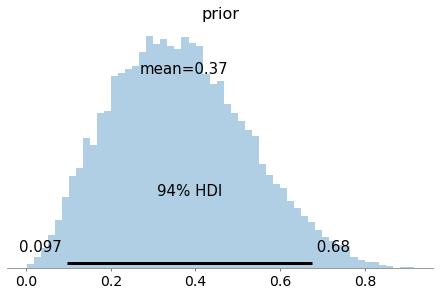

In [4]:
with our_model:
    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"));

While we won't go through all of the data in the summary table (you can read what each element of the table refers to in [the docs](https://arviz-devs.github.io/arviz/api/generated/arviz.summary.html)). We will talk about _r\_hat_ (i.e. $\hat{R}$). This tells us how consistent the (in the case 4x) chains are. A score of 1. is ideal suggesting that the chains all behave similarly ... a measure of confidence in our result. _mcse\_mean_ and _mcse\_sd_ refer to Monte Carlo Standard Error Mean/Standard Deviation and are both low supporting this. 

However, we are more interested in the first four elements which are also represented in our chart. We have a mean value in the posterior of 0.37 ... very close to our real $\theta$ value of 0.35. Great news ... our model has done its job. The distribution has standard deviation of 0.159. Finally we have _hdi\_3%_ and _hdi\_97%_ (where HDI stands for High Density Interval). This is basically the range of values we will consider in our distribution as we ignore the bottom and top 3% as potential noise. This is comparable to the frequentist notion of a confidence interval, typically called a credible interval in Bayesian terminology ... roughly saying we are 94% confident the true average of this distribution is between 0.097 and 0.676.

This is, however, a wide range. Let's see what would happen if we increase the amount of data (likelihood) we have:

In [5]:
# increasing trials
trials = 100 # increaing from 4x trials to 100x
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

In [6]:
with pm.Model() as our_model_two:
    prior = pm.Beta('prior', alpha=2., beta=2.)
    y = pm.Bernoulli('y', p=prior, observed=data)
    trace = pm.sample(5000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 46 seconds.


Summary DF
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
prior  0.394  0.047   0.303     0.48        0.0      0.0    9717.0  9717.0   

       ess_bulk  ess_tail  r_hat  
prior    9713.0   13595.0    1.0  


HDI
AxesSubplot(0.125,0.125;0.775x0.755)


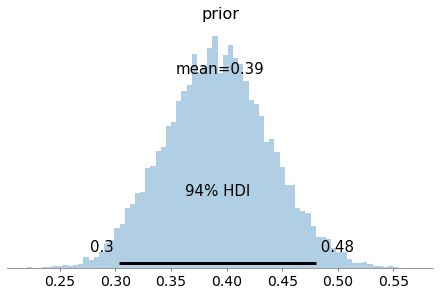

In [7]:
with our_model_two:
    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"));

We can see that there is a slight increase to the mean but only very minor. More interestingly the standard deviation of the distribution is now only 0.047 (from 0.159) and the 94% HDI is now 0.303-0.48 (from 0.097-0.676). Our model has got much more confident which is what we may expect given it has 25x the data.

As another experiment, let's return to just 4x examples, but this time with a different prior. Our previous prior was $\alpha=2$ and $\beta=2$ ... basically saying we think it is an unbiased coin. Let's try a prior that represents a belief that the coin is biased towards heads. Now we know this is incorrect. The real, unknown $\theta$ value is actually $p=0.35$ for heads, so this experiment will see the effect of a bad prior: 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.


Summary DF
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
prior  0.547  0.144   0.281    0.809      0.002    0.001    8888.0  8888.0   

       ess_bulk  ess_tail  r_hat  
prior    9038.0   14313.0    1.0  


HDI
AxesSubplot(0.125,0.125;0.775x0.755)


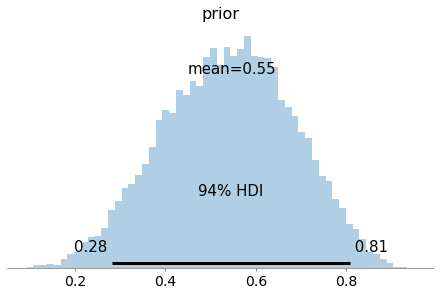

In [8]:
trials = 4 # effectively 4x coin tosses
data = stats.bernoulli.rvs(p=theta_real, size=trials)

with pm.Model() as our_model_three:
    prior = pm.Beta('prior', alpha=5., beta=2.)
    y = pm.Bernoulli('y', p=prior, observed=data)
    trace = pm.sample(5000, random_seed=123, return_inferencedata=True)

    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"));

Our new experiment shows similar levels of uncertainty (as measured by standard deviation and HDI) as our original model. The big difference now is that we have a mean of 0.55 (compared to our original 0.37 and our real $\theta$ of 0.35). The prior has won out and we now predict the coin to have a very slight bias towards heads.

How about if we keep this biased prior (towards heads) but use 100x coin toss trials:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 47 seconds.


Summary DF
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
prior  0.411  0.047   0.326    0.501        0.0      0.0    8952.0  8952.0   

       ess_bulk  ess_tail  r_hat  
prior    8981.0   13310.0    1.0  


HPD
AxesSubplot(0.125,0.125;0.775x0.755)


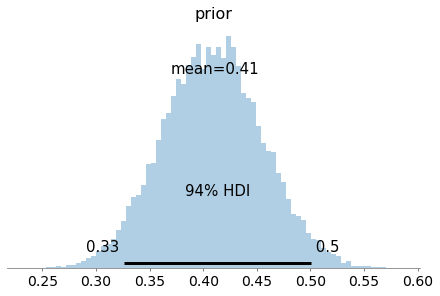

In [9]:
trials = 100 # 100x coin tosses
data = stats.bernoulli.rvs(p=theta_real, size=trials)

with pm.Model() as our_model_three:
    prior = pm.Beta('prior', alpha=5., beta=2.)
    y = pm.Bernoulli('y', p=prior, observed=data)
    trace = pm.sample(5000, random_seed=123, return_inferencedata=True)

    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"));

Given more data the model has learned to largely ignore our incorrect prior. The mean is a few points higher than our initial experiments (and our model is slightly more uncertain), but largely speaking the real bias in the coin (towards tails not heads as our prior suggested) has been corrected for by the data.

## Summary
This Notebook has shown us working with Bayesian methods for distributions of data. We have seen the MCMC trick for dealing with the difficulty of calculating $P(B)$ (a trick that also comes up in AI and deep learning systems), and the impact of different amounts of data and different priors. Our final Notebook in this mini-series will give us one more example of Bayes in ML, a Bayesian alternative to a familiar algorithm!